# Task 3.2 - Analysis Report Preparation
## Project Structure

This notebook contains the solution to Task 3.2:

```
Make a forecast on the DAU index for the period of 3 months of 2018 (January 1st–March 31st). Please specify the method and approach used to build the predicted values.
```

The analysis is structured as follows:

1. **Data Preprocessing**  
   Data cleaning and preparation were performed for further analysis.

2. **DAU Visualization**  
   Plotted daily active users (DAU) charts to assess trends and seasonality.

3. **Model Selection and Forecasting**  
   Selected the most suitable time series model, trained it, and generated the forecast.

4. **Model Evaluation**  
   Split the available data into training and validation sets to evaluate the model’s performance and calculate its accuracy.

5. **Final Forecast Values and Method Explanation**  
   Presented the final forecasted values along with a brief explanation of the forecasting method used.

In [35]:
import os
import warnings
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from prophet import Prophet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import (
    make_scorer,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    root_mean_squared_error,
)
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sqlalchemy import create_engine, text
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 1. Data Preprocessing in PostgresSQL

Agregate and create Dataframe with data:

In [38]:
env_path = "/Users/alena/MyPythonProjects/dataPS.env"
load_dotenv(dotenv_path=env_path)

db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_host = os.getenv("DB_HOST", "localhost")
db_port = os.getenv("DB_PORT", "5432")
db_name = os.getenv("DB_NAME")

In [40]:
engine = create_engine(
    f"postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
)

In [42]:
sample_data = text(
    """
  SELECT DISTINCT 
      TO_DATE(day_id, 'DD/MM/YY') AS day, 
      dau
  FROM dau_data
  
  WHERE dau IS NOT NULL 
      AND day_id IS NOT NULL

  ORDER BY day
  ;
    """
)
with engine.connect() as conn:
    df_sample_data = pd.read_sql(sample_data, conn)

## Functions

In [150]:
def compute_metrics(true: np.ndarray, predicted: np.ndarray) -> dict:
    """
    Compute various error metrics between true and predicted values.

    Args:
        true: Array-like object containing actual values
        predicted: Array-like object containing predicted values

    Returns:
        dict: Dictionary containing RMSE, MAE, MAPE, and R2 metrics
    """
    # Convert inputs to numpy arrays
    true = pd.Series(true).values
    predicted = pd.Series(predicted).values

    # Calculate MAPE only for non-zero true values
    mask = true != 0
    mape = (
        np.mean(np.abs((true[mask] - predicted[mask]) / true[mask])) * 100
        if mask.sum() > 0
        else np.nan
    )

    # Return dictionary of metrics
    return {
        "RMSE": root_mean_squared_error(true, predicted),
        "MAE": mean_absolute_error(true, predicted),
        "MAPE": mape,
        "R2": r2_score(true, predicted),
    }


def plot_forecast(
    dates: np.ndarray, actual: np.ndarray, predicted: np.ndarray, title: str
) -> None:
    """
    Plot actual vs predicted values over time.

    Args:
        dates: Array of dates for x-axis
        actual: Array of actual values
        predicted: Array of predicted values
        title: Title for the plot
    """
    plt.figure(figsize=(12, 4))

    # Only plot actual line if it differs from predicted
    if not np.array_equal(actual, predicted):
        plt.plot(dates, actual, label="Actual")

    plt.plot(dates, predicted, label="Forecast")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


def plot_forecast_with_ci(dates, actual, predicted, lower_ci, upper_ci, title):
    plt.figure(figsize=(14, 6))
    # Only plot actual line if it differs from predicted
    if not np.array_equal(actual, predicted):
        plt.plot(dates, actual, label="Actual")
    plt.plot(dates, predicted, label="Forecast")
    plt.fill_between(
        dates,
        lower_ci,
        upper_ci,
        alpha=0.2,
        color="gray",
        label="Confidence Interval",
    )
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("DAU")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def add_seasonality(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add cyclical features for weekly and yearly seasonality.

    Args:
        df: DataFrame containing a 'day_number' column

    Returns:
        pd.DataFrame: DataFrame with added seasonality features
    """
    # Weekly seasonality (7-day cycle)
    df["sin_week"] = np.sin(2 * np.pi * df["day_number"] / 7)
    df["cos_week"] = np.cos(2 * np.pi * df["day_number"] / 7)

    # Yearly seasonality (365-day cycle)
    df["sin_year"] = np.sin(2 * np.pi * df["day_number"] / 365)
    df["cos_year"] = np.cos(2 * np.pi * df["day_number"] / 365)

    return df

# 2. DAU Visualization

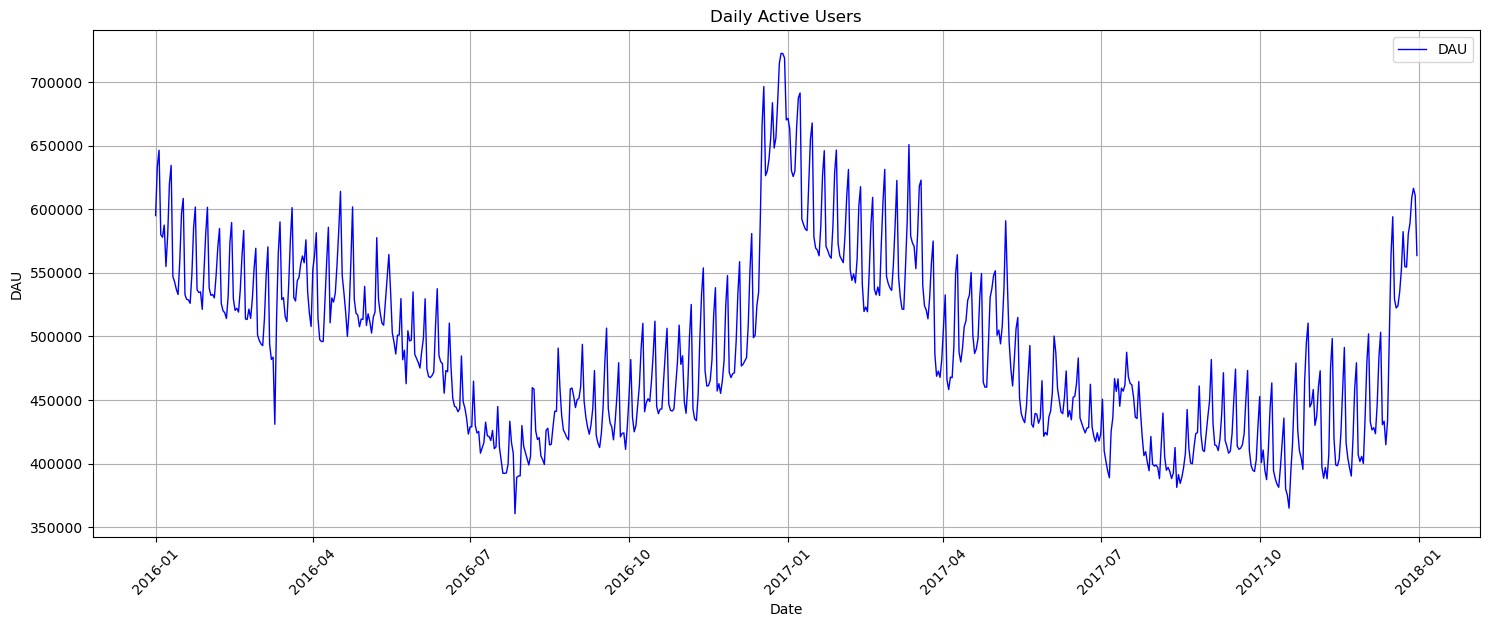

In [81]:
plt.figure(figsize=(15, 6))
plt.plot(
    df_sample_data["day"], df_sample_data["dau"], label="DAU", color="blue", linewidth=1
)

plt.title("Daily Active Users")
plt.xlabel("Date")
plt.ylabel("DAU")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.xticks(rotation=45)

plt.show()

## Key Data Features from Preprocessing

1. **Annual seasonality** — noticeable drops and rises during different months of the year.  
2. **Spikes observed** — significant spike in December 2017 and a smaller one in 2018.  
3. **Weekly fluctuations** — patterns reflecting weekends and weekdays.

# 3. Model Selection and Forecasting

Given the pronounced seasonality in the data, the forecasting model needs to account for three key components: noise, trend, and seasonality. Two models appear most suitable for this task:

1. **SARIMAX**
   A traditional time series model that explicitly models trend, seasonality, and noise by combining autoregression, differencing, and moving averages. It requires manual tuning of parameters and is well-suited for data with strong seasonal patterns.

2. **Prophet**  
   A more flexible, additive model developed by Facebook, designed to handle seasonality, holidays, and trend changes automatically. It is user-friendly and robust to missing data and outliers.

3. **SARIMAX** (SARIMA + external regressor `is_weekend`)  
  An extension of SARIMA that includes external regressors — in this case, a binary weekend indicator (`is_weekend` and `holiday`). This allows modeling the influence of external factors on user behavior.

4. **Gradient Boosting Regressor (GBR)**  
  A tree-based ensemble model that captures nonlinear relationships in data. It can be applied to DAU forecasting when enriched with multiple features, including time-based and external variables.


I will develop forecasts using both models based on the 2016 data, then evaluate their performance on the 2017 data. Finally, I will compare the results to determine which model provides better accuracy.

## Gradient Boosting Regressor
### Gradient Boosting Regression Pipeline

Gradient Boosting was used as a non-linear machine learning baseline to test the predictive value of engineered time-series features. The pipeline was structured as follows:

1. **Feature Engineering**: Created a feature matrix from the date column, extracting:
   - `day_of_week`, `is_weekend`, `month`, `day_of_month`
   - `week_of_year`, and additional lagged values if needed.
2. **Data Splitting**: Divided the feature-enriched dataset into training and test subsets with temporal order preserved.
3. **Hyperparameter Tuning**: Performed grid search with cross-validation on the training set using scikit-learn’s `GradientBoostingRegressor`. Evaluation metric: negative RMSE.
4. **Model Selection**: Chose the best estimator based on cross-validated RMSE, and retrained it on the full training set.
5. **Validation Evaluation**: Generated predictions on the test set and computed standard regression metrics (RMSE, MAE, MAPE, R²).
7. **Final Training and Forecasting**: Trained the model on the full historical dataset and forecasted DAU for **January 1 – March 31, 2018** using extrapolated calendar-based features.
8. **Visualization**: Plotted forecasted values for test and future periods to visualize fit quality and deviations.

Fitting 6 folds for each of 27 candidates, totalling 162 fits
[GBR] Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
[GBR] RMSE (CV): 62131.43421567527
[GBR] Test Metrics: {'RMSE': 54872.86309089821, 'MAE': 43382.83409407957, 'MAPE': 9.489370843628803, 'R2': 0.24839997461556906}


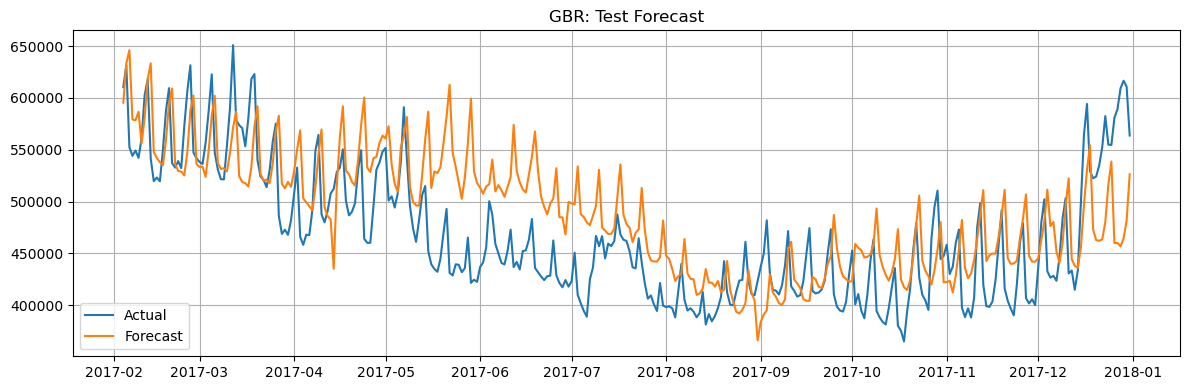

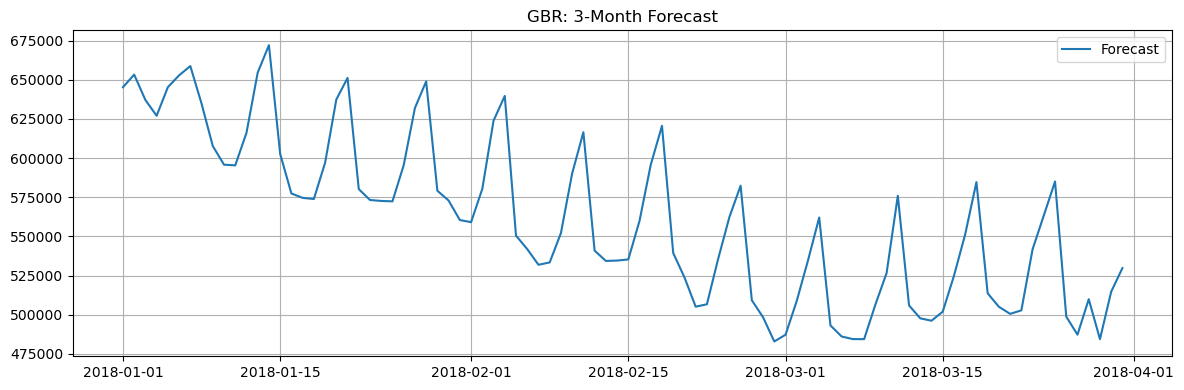

In [71]:
# Main execution
data = df_sample_data.copy().sort_values("day")
data["day"] = pd.to_datetime(data["day"])

# Prepare data
data_train = data[:400].copy()
data_test = data[400:].copy()

# Add features
data_train["day_number"] = np.arange(len(data_train))
data_test["day_number"] = np.arange(len(data_test))

add_seasonality(data_train)
add_seasonality(data_test)

features = ["day_number", "sin_week", "cos_week", "sin_year", "cos_year"]

X_train, y_train = data_train[features], data_train["dau"]
X_test, y_test = data_test[features], data_test["dau"]

# Train a Gradient Boosting Regressor with hyperparameter tuning
tscv = TimeSeriesSplit(n_splits=6)
param_grid = {
    "n_estimators": [100, 300, 500],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [3, 5, 7],
}

scorer = make_scorer(mean_squared_error, greater_is_better=False)
grid_search = GridSearchCV(
    GradientBoostingRegressor(),
    param_grid,
    scoring=scorer,
    cv=tscv,
    n_jobs=-1,
    verbose=1,
)
grid_search.fit(X_train, y_train)

print("[GBR] Best params:", grid_search.best_params_)
print("[GBR] RMSE (CV):", np.sqrt(-grid_search.best_score_))

# Evaluate model
gbr_model = grid_search.best_estimator_
y_pred = gbr_model.predict(X_test)
print("[GBR] Test Metrics:", compute_metrics(y_test, y_pred))
plot_forecast(data_test["day"], y_test, y_pred, "GBR: Test Forecast")

# Generate future forecast
future_dates = pd.date_range("2018-01-01", "2018-03-31")
future_df = pd.DataFrame({"day": future_dates})
future_df["day_number"] = np.arange(
    len(data_train) + len(data_test),
    len(data_train) + len(data_test) + len(future_dates),
)
add_seasonality(future_df)

X_future = future_df[features]
y_future_pred = gbr_model.predict(X_future)
plot_forecast(future_df["day"], y_future_pred, y_future_pred, "GBR: 3-Month Forecast")

## SARIMA

### Modeling Pipeline Overview

The SARIMA modeling process was designed to rigorously handle complex seasonal structures in the DAU time series. The following steps outline the end-to-end approach:

1. **Yearly Seasonality Removal**: Decomposed and removed the yearly seasonal component to better isolate short-term and weekly trends.
2. **Data Partitioning**: Split the dataset (`df_sample_data`) into training, validation, and test sets to ensure robust model tuning and evaluation.
3. **Seasonality Modeling with ARIMA**: Trained a univariate ARIMA model on the training set to forecast the yearly seasonality component separately.
4. **Hyperparameter Tuning for SARIMA**: Performed grid search on the deseasonalized training set to identify optimal SARIMA parameters based on time-series cross-validation.
5. **Initial Model Training**: Trained SARIMA on the deseasonalized training set using the selected hyperparameters, and combined its predictions with the previously estimated seasonal component.
6. **Validation Evaluation**: Assessed model performance on the validation set by reintroducing the seasonal component and computing RMSE, MAE, MAPE, and R².
7. **Retraining on Expanded Data**: Refit the SARIMA model on the combined train + validation set to incorporate more data and improve generalization, again combining with the seasonality forecast.
8. **Extended Evaluation**: Evaluated model accuracy on the combined train + validation set using the same performance metrics.
9. **Final Model Training**: Trained the final SARIMA model on the full dataset (train + validation + test), including both the deseasonalized series and the seasonal component.
10. **Forward Forecasting**: Generated out-of-sample forecasts for the period **January 1 – March 31, 2018**.
11. **Visualization**: Visualized forecasts for the validation and test windows, as well as the future 3-month horizon, including confidence intervals to communicate uncertainty.

[SARIMA] Validation Metrics: {'RMSE': 19597.219438691736, 'MAE': 13802.395133055003, 'MAPE': 3.086510356376353, 'R2': 0.8455240595919995}


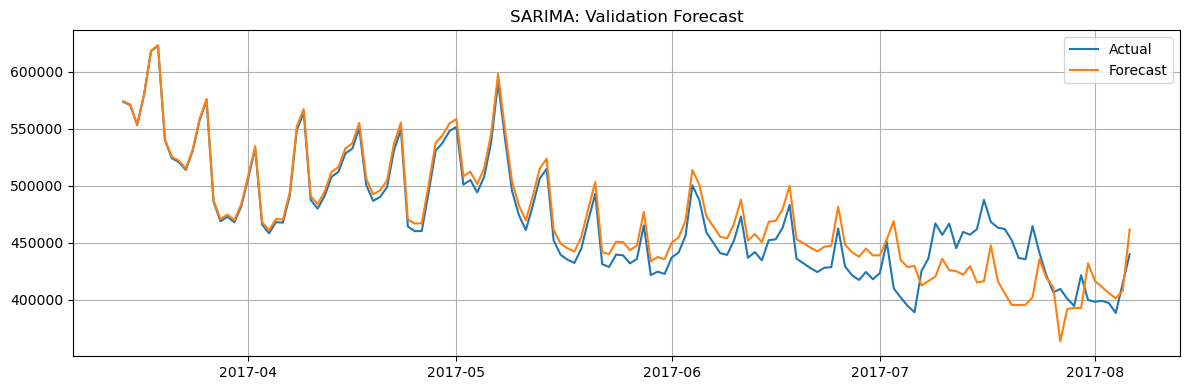

[SARIMA] Test Metrics: {'RMSE': 51713.361276618074, 'MAE': 40261.64044497447, 'MAPE': 8.967430188029459, 'R2': 0.1103898222307006}


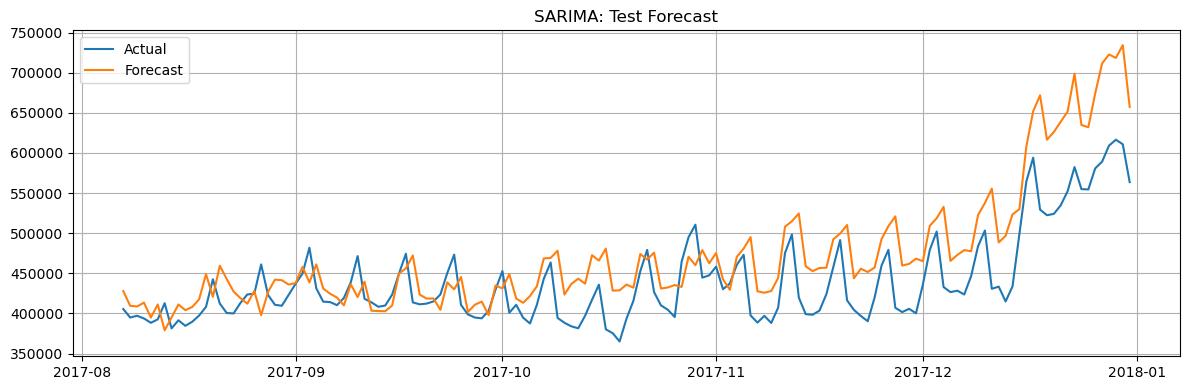

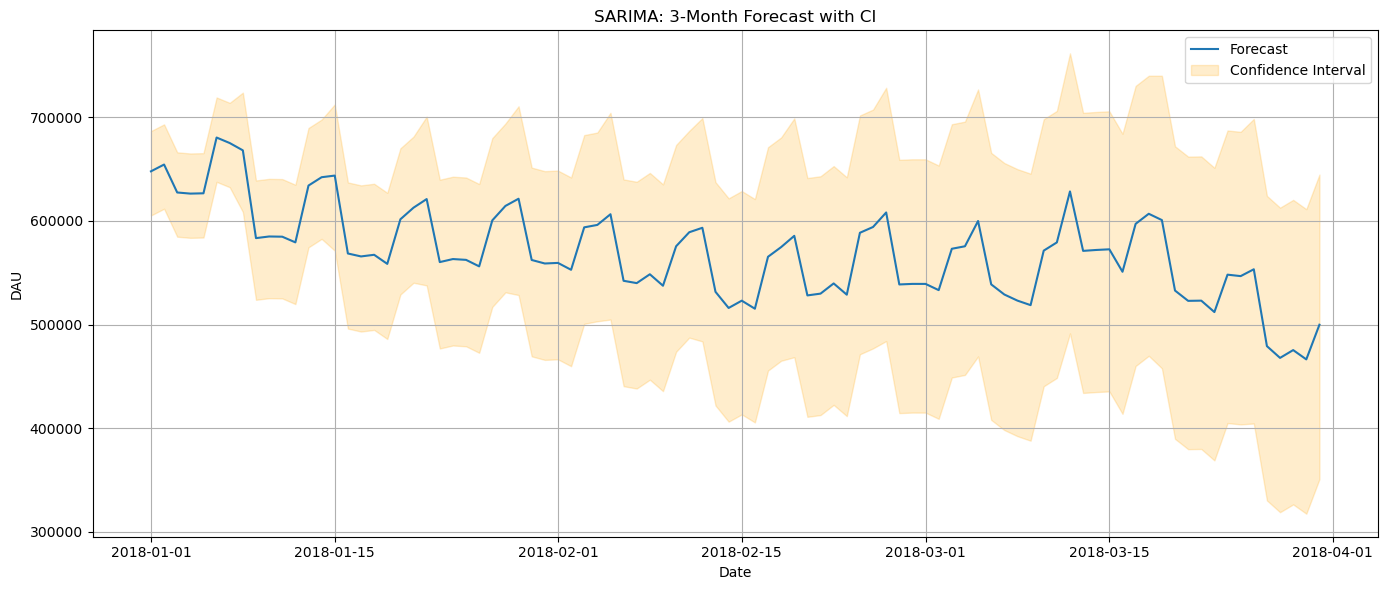

In [132]:
# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="statsmodels")
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Main execution
sarima_df = df_sample_data.copy().sort_values("day").set_index("day").asfreq("D")

# Using additive model with yearly seasonality (365 days)
decomposition = seasonal_decompose(sarima_df["dau"], model="additive", period=365)
# Remove seasonal component from original data to get deseasonalized series
sarima_df["deseasonalized"] = sarima_df["dau"] - decomposition.seasonal
# Store the seasonal component for later use
seasonal_part = decomposition.seasonal

# Prepare data for training, validation and testing
train_end = int(len(sarima_df) * 0.6)
val_end = int(len(sarima_df) * 0.8)

# Create the data splits
train = sarima_df.iloc[:train_end]
validation = sarima_df.iloc[train_end:val_end]
test = sarima_df.iloc[val_end:]
train_val = sarima_df.iloc[:val_end]

# Grid search for optimal SARIMA parameters
params = list(product(range(2), repeat=6))
best_score = float("inf")  # Initialize best score with infinity for minimization

for order_vals in params:
    try:
        order, seasonal_order = order_vals[:3], order_vals[3:] + (7,)
        # Create SARIMAX model with the deseasonalized training data
        model = SARIMAX(
            train["deseasonalized"],
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        result = model.fit(disp=False)

        # Generate forecast for validation period and add back seasonal component
        forecast = (
            result.predict(start=validation.index[0], end=validation.index[-1])
            + seasonal_part.loc[validation.index]
        )
        score = mean_squared_error(validation["dau"], forecast)
        if score < best_score:
            best_order, best_seasonal_order = order, seasonal_order
            best_score = score
    except:
        continue

# Create final SARIMA model for validation using best parameters
model = SARIMAX(
    train["deseasonalized"],
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit(disp=False)

# Generate forecast for validation period and add back seasonal component
forecast_val = (
    model.predict(start=validation.index[0], end=validation.index[-1])
    + seasonal_part.loc[validation.index]
)

# Print validation metrics and plot validation forecast
print("[SARIMA] Validation Metrics:", compute_metrics(validation["dau"], forecast_val))
plot_forecast(
    validation.index, validation["dau"], forecast_val, "SARIMA: Validation Forecast"
)

# Retrain model on combined train+validation data for test forecasting
model = SARIMAX(
    train_val["deseasonalized"],
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit(disp=False)

# Generate forecast for test period and add back seasonal component
forecast_test = (
    model.predict(start=test.index[0], end=test.index[-1])
    + seasonal_part.loc[test.index]
)
# Print test metrics and plot test forecast
print("[SARIMA] Test Metrics:", compute_metrics(test["dau"], forecast_test))
plot_forecast(test.index, test["dau"], forecast_test, "SARIMA: Test Forecast")

# Create date range for future 90-day forecast
future_index = pd.date_range(sarima_df.index[-1] + pd.Timedelta(days=1), periods=90)

# Generate future forecast and add seasonal component (reusing last year's seasonality)
forecast_future = model.predict(start=future_index[0], end=future_index[-1]) + np.tile(
    seasonal_part[-365:].values[:90], 1
)

# Forecast 90 days into future with CI
forecast_obj_future = model.get_forecast(steps=90)
ci_future = forecast_obj_future.conf_int()
forecast_mean_future = forecast_obj_future.predicted_mean + np.tile(seasonal_part[-365:].values[:90], 1)
ci_future += np.tile(seasonal_part[-365:].values[:90], (2, 1)).T  # shape match

# Plot with CI
plot_forecast_with_ci(
    future_index,
    forecast_future,
    forecast_future,  # includes seasonal shift
    ci_future.iloc[:, 0],
    ci_future.iloc[:, 1],
    "SARIMA: 3-Month Forecast with CI"
)


## SARIMAX

### SARIMAX Modeling Pipeline Overview

The SARIMAX model was developed to capture both temporal seasonality and exogenous effects associated with weekly behavioral patterns in DAU. The pipeline incorporated a binary external regressor `is_weekend` to account for systematic weekend variations. Below is a structured breakdown of the modeling workflow:

1. **Data Partitioning**: Divided the full dataset (`df_sample_data`) into training, validation, and test subsets to enable robust model selection and evaluation.
2. **Incorporation of External Regressor**: Augmented the feature set by adding the binary variable `is_weekend`, representing whether each observation occurred on a weekend.
3. **Hyperparameter Tuning**: Applied grid search over SARIMAX configurations on the deseasonalized training set, optimizing model parameters using time-series cross-validation.
4. **Initial Model Training**: Trained the SARIMAX model on the training set, including the `is_weekend` regressor and yearly seasonality, using the best hyperparameters obtained from tuning.
5. **Validation Evaluation**: Evaluated model performance using standard error metrics (RMSE, MAE, MAPE, R²).
6. **Model Retraining on Expanded Data**: Refit the SARIMAX model on the combined train + validation data to improve generalizability and better capture temporal dependencies and external effects.
7. **Extended Evaluation**: Assessed the model's performance on the train + validation set.
8. **Final Model Training**: Trained the final SARIMAX model on the entire dataset (train + validation + test), leveraging all available historical data and external regressor signals.
9. **Forward Forecasting**: Generated a 3-month forecast for the out-of-sample period **January 1 – March 31, 2018**, including the impact of weekend dynamics.
10. **Visualization**: Produced visualizations for validation and test windows, along with the 3-month forward forecast, including confidence intervals to quantify prediction uncertainty.

[SARIMAX] Validation Metrics: {'RMSE': 20001.391085610176, 'MAE': 13415.880444094366, 'MAPE': 3.011588986960772, 'R2': 0.8390865523926818}


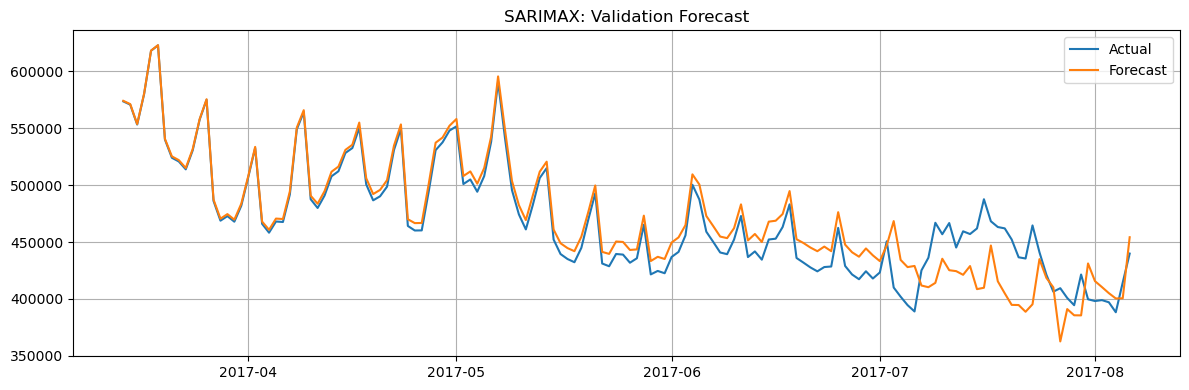

[SARIMAX] Test Metrics: {'RMSE': 50786.84498715533, 'MAE': 39452.48433642643, 'MAPE': 8.787044655580976, 'R2': 0.14198145026898878}


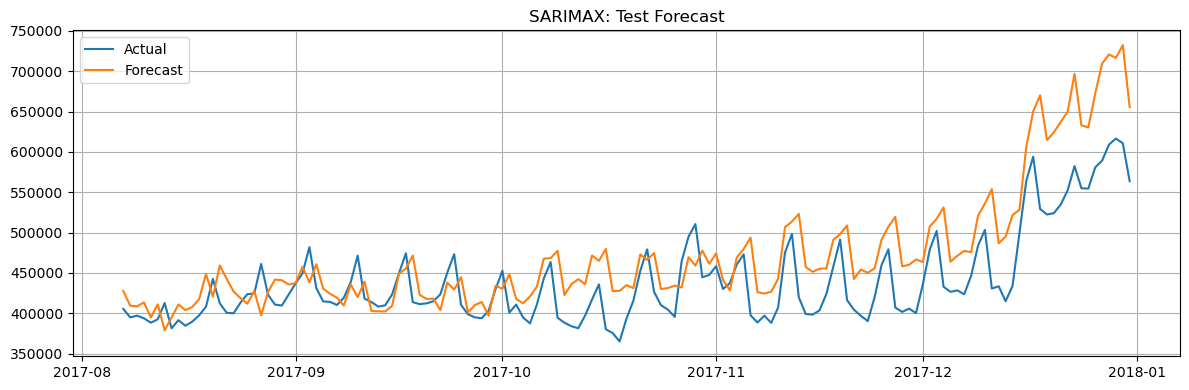

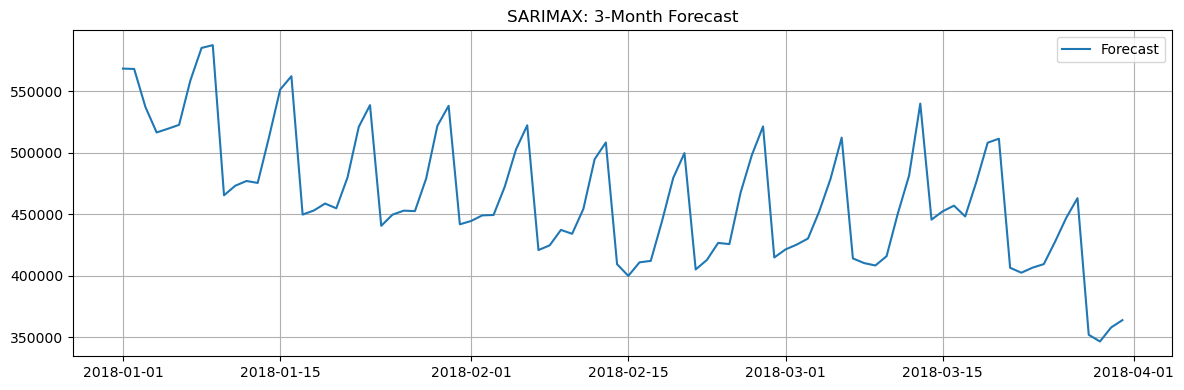

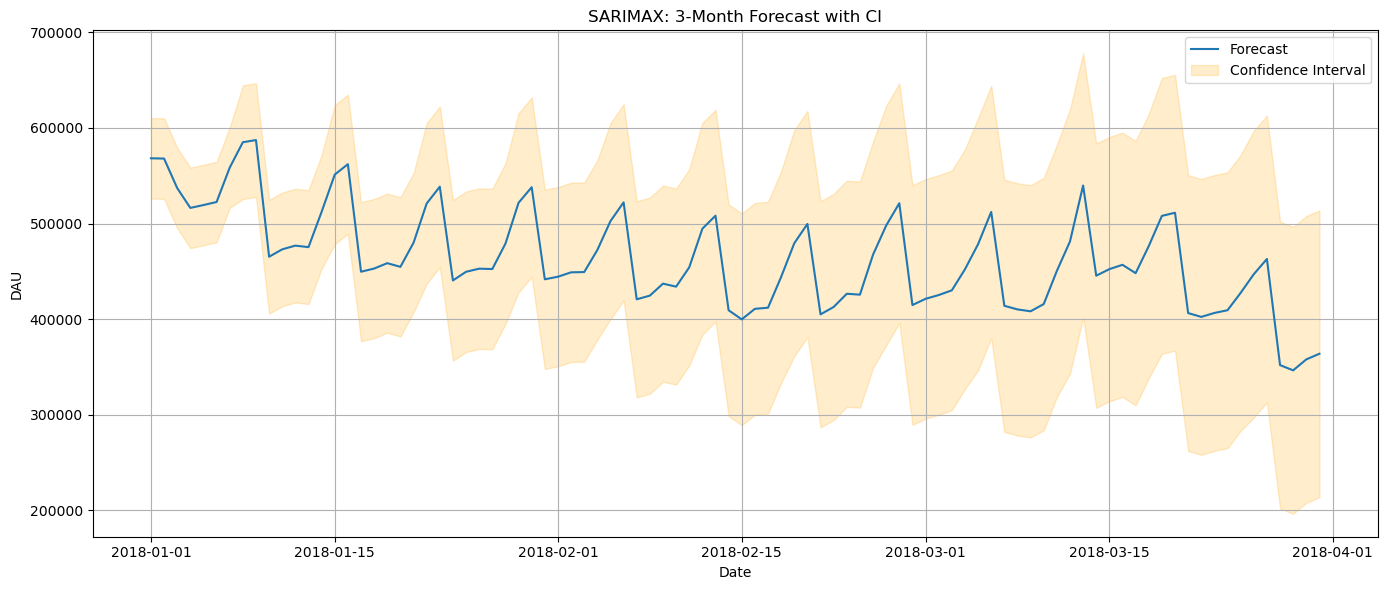

In [138]:
# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="statsmodels")
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Main execution
sarimax_df = df_sample_data.copy()

# Convert 'day' column to datetime and set it as index with daily frequency
sarimax_df["day"] = pd.to_datetime(sarimax_df["day"])
sarimax_df = sarimax_df.sort_values("day").set_index("day").asfreq("D")

# Create a binary feature for weekends
sarimax_df["is_weekend"] = sarimax_df.index.weekday >= 5

# Decompose the time series to extract seasonal component with yearly seasonality
decomposition = seasonal_decompose(sarimax_df["dau"], model="additive", period=365)
# Remove seasonality from the original data
sarimax_df["deseasonalized"] = sarimax_df["dau"] - decomposition.seasonal
seasonal_part = decomposition.seasonal

# Split data into train, validation and test sets
train = sarimax_df.iloc[:train_end]
validation = sarimax_df.iloc[train_end:val_end]
test = sarimax_df.iloc[val_end:]
train_val = sarimax_df.iloc[:val_end]

# Initialize variable to track best model performance
best_score = float("inf")

# Grid search through different SARIMAX parameters
for order_vals in params:
    try:
        # Extract ARIMA order and seasonal order parameters
        order, seasonal_order = order_vals[:3], order_vals[3:] + (7,)

        # Fit SARIMAX model on deseasonalized data with weekend as exogenous variable
        model = SARIMAX(
            train["deseasonalized"],
            exog=train[["is_weekend"]],
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        result = model.fit(disp=False)

        # Generate forecasts for validation period and add back seasonal component
        forecast = (
            result.predict(
                start=validation.index[0],
                end=validation.index[-1],
                exog=validation[["is_weekend"]],
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            + seasonal_part.loc[validation.index]
        )

        score = mean_squared_error(validation["dau"], forecast)
        if score < best_score:
            best_order, best_seasonal_order = order, seasonal_order
            best_score = score
    except:
        continue

# Train SARIMAX model with best parameters on training data
model = SARIMAX(
    train["deseasonalized"],
    exog=train[["is_weekend"]],
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit(disp=False)

# Generate forecasts for validation period
forecast_val = (
    model.predict(
        start=validation.index[0],
        end=validation.index[-1],
        exog=validation[["is_weekend"]],  # Use validation exogenous variables
    )
    + seasonal_part.loc[validation.index]  # Add back seasonal component
)

# Evaluate and visualize validation results
print("[SARIMAX] Validation Metrics:", compute_metrics(validation["dau"], forecast_val))
plot_forecast(
    validation.index, validation["dau"], forecast_val, "SARIMAX: Validation Forecast"
)

# Retrain model on combined training+validation data for test predictions
model = SARIMAX(
    train_val["deseasonalized"],
    exog=train_val[["is_weekend"]],
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit(disp=False)

# Generate forecasts for test period
forecast_test = (
    model.predict(start=test.index[0], end=test.index[-1], exog=test[["is_weekend"]])
    + seasonal_part.loc[test.index]  # Add back seasonal component
)

# Evaluate and visualize test results
print("[SARIMAX] Test Metrics:", compute_metrics(test["dau"], forecast_test))
plot_forecast(test.index, test["dau"], forecast_test, "SARIMAX: Test Forecast")

# Create future date range for forecasting (Q1 2018)
future_index = pd.date_range(start="2018-01-01", end="2018-03-31")

# Create exogenous variables for future dates (weekend indicators)
future_exog = pd.DataFrame(
    {"is_weekend": future_index.weekday >= 5}, index=future_index
)

# Train final model on all available data
model = SARIMAX(
    sarimax_df["deseasonalized"],
    exog=sarimax_df[["is_weekend"]],
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit(disp=False)

# Generate future forecasts
forecast_future = (
    model.predict(start=future_index[0], end=future_index[-1], exog=future_exog)
    + seasonal_part[: len(future_index)].values  # Add back seasonal component
)

# Forecast 90 days into future with CI
forecast_obj_future = model.get_forecast(steps=len(future_index), exog=future_exog)
forecast_mean_future = forecast_obj_future.predicted_mean + seasonal_part[: len(future_index)].values
ci_future = forecast_obj_future.conf_int()
ci_future += seasonal_part[: len(future_index)].values.reshape(-1, 1)

# Plot with CI
plot_forecast_with_ci(
    future_index,
    forecast_future,
    forecast_future,  # includes seasonal shift
    ci_future.iloc[:, 0], ci_future.iloc[:, 1],
    "SARIMAX: 3-Month Forecast with CI"
)

## Prophet
### Prophet Modeling Pipeline (with `is_weekend` and `holiday` Regressor)

The Prophet model was used as a flexible baseline capable of modeling non-linear trends and multiple seasonalities, augmented with the `is_weekend` regressor to capture binary effects of weekends. The modeling process included:

1. **Data Preprocessing**: Transformed the original dataset into Prophet’s expected format, renaming columns to `ds` (timestamp) and `y` (target metric, DAU).  
2. **Feature Engineering**: Added a custom binary regressor `is_weekend` and `holiday` to account for weekly behavioral shifts.
3. **Model Configuration**: Initialized the Prophet model with default trend and seasonality components (`weekly_seasonality=True`, `yearly_seasonality=True`), and included `is_weekend` and `holiday` as an external regressor.
4. **Training**: Fitted the model on the training set, including all regressors and seasonal components.
5. **Validation Forecasting**: Generated forecasts on the validation set and evaluated performance using RMSE, MAE, MAPE, and R² metrics.
6. **Extended Training**: Refit the model on the combined train + validation set for improved stability and generalization.
7. **Full Fit and Forecasting**: Trained the final model on the full dataset (train + validation + test) and produced a forward forecast for **January 1 – March 31, 2018**.
8. **Visualization**: Displayed forecasts with confidence intervals for validation, test, and future windows to assess forecast accuracy and model uncertainty.

15:51:23 - cmdstanpy - INFO - Chain [1] start processing
15:51:23 - cmdstanpy - INFO - Chain [1] done processing


[Prophet] Validation Metrics: {'RMSE': 61673.24171606895, 'MAE': 54970.30510946768, 'MAPE': 11.883371322921283, 'R2': -0.5299086143132978}


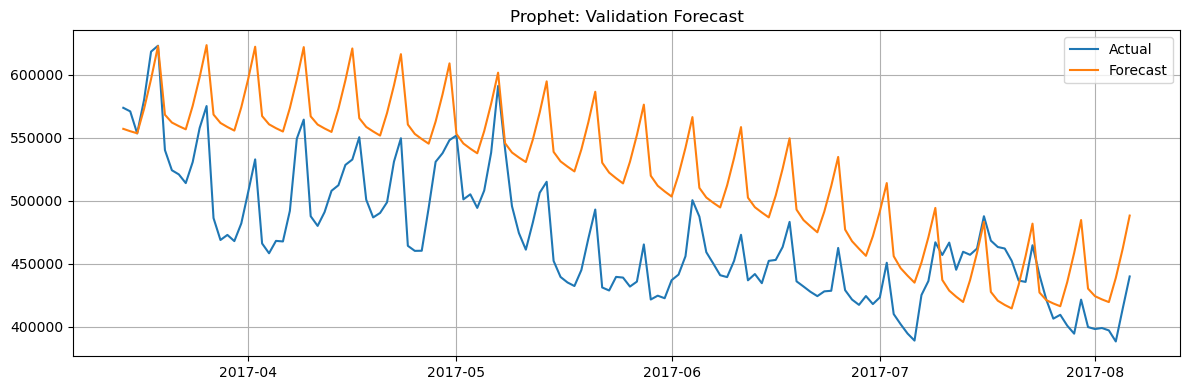

15:51:23 - cmdstanpy - INFO - Chain [1] start processing
15:51:23 - cmdstanpy - INFO - Chain [1] done processing


[Prophet] Test Metrics: {'RMSE': 96836.29224249213, 'MAE': 83954.62339144202, 'MAPE': 18.87067657154267, 'R2': -2.119396019394759}


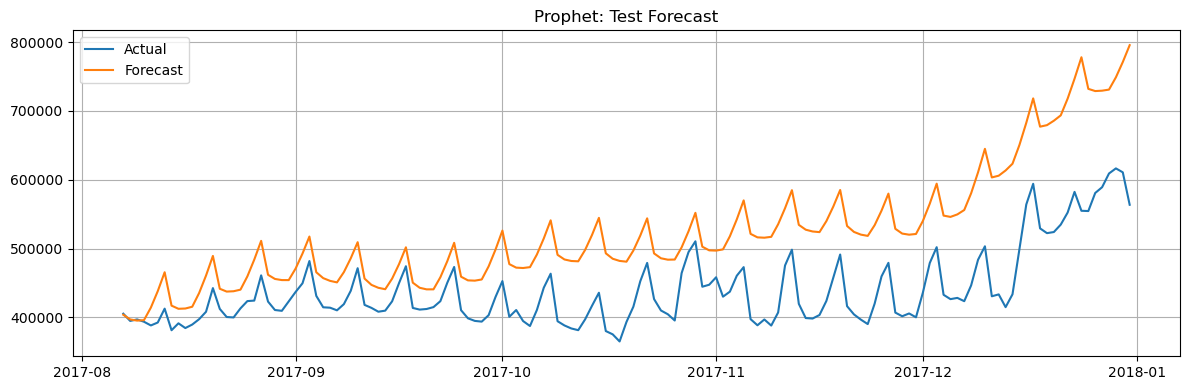

15:51:23 - cmdstanpy - INFO - Chain [1] start processing
15:51:23 - cmdstanpy - INFO - Chain [1] done processing


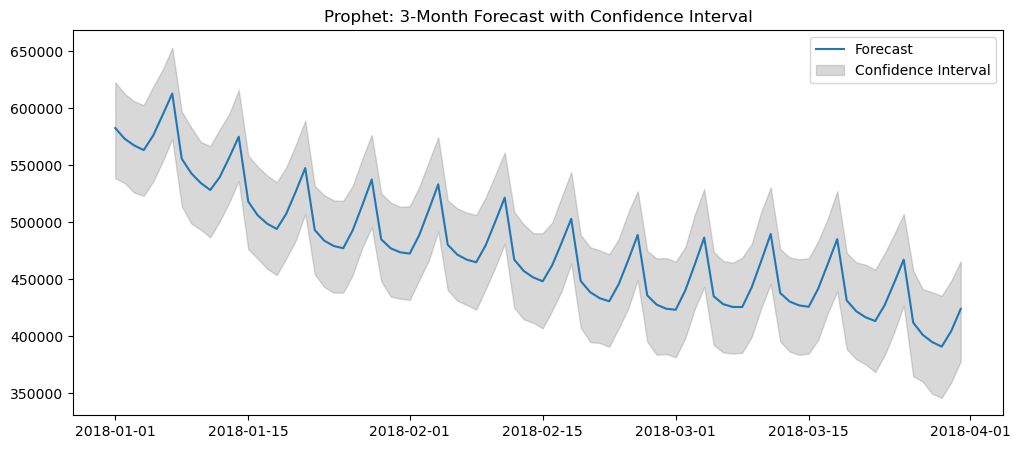

In [152]:
# Main execution
prophet_df = df_sample_data.copy().rename(columns={"day": "ds", "dau": "y"})

# Convert date column to datetime format
prophet_df["ds"] = pd.to_datetime(prophet_df["ds"])

# Create a binary feature indicating if the date is a weekend (1) or weekday (0)
prophet_df["is_weekend"] = (prophet_df["ds"].dt.weekday >= 5).astype(int)

# Split data into training, validation and test sets
train = prophet_df.iloc[:train_end]
validation = prophet_df.iloc[train_end:val_end]
test = prophet_df.iloc[val_end:]
train_val = prophet_df.iloc[:val_end]  # Combined training and validation for later use

# Define holiday dataframe for December holidays in 2016 and 2017
holidays = pd.DataFrame(
    {
        "holiday": "december_holiday",
        "ds": pd.date_range("2016-12-01", "2016-12-31").union(
            pd.date_range("2017-12-01", "2017-12-31")
        ),
        "lower_window": 0,
        "upper_window": 0,
    }
)

# Initialize first Prophet model with seasonality and holiday effects
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    holidays=holidays,
    holidays_prior_scale=10,
)
model.add_regressor("is_weekend")

# Fit model on training data
model.fit(train)

# Generate and evaluate predictions on validation set
forecast_val = model.predict(validation[["ds", "is_weekend"]])
forecast_val = (
    forecast_val.set_index("ds").reindex(validation["ds"]).reset_index()
)  # Align with validation dates
print(
    "[Prophet] Validation Metrics:",
    compute_metrics(validation["y"], forecast_val["yhat"]),
)
plot_forecast(
    validation["ds"],
    validation["y"],
    forecast_val["yhat"],
    "Prophet: Validation Forecast",
)

# Initialize second Prophet model (without holidays) for test set prediction
model2 = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model2.add_regressor("is_weekend")
model2.fit(train_val)

# Generate and evaluate predictions on test set
forecast_test = model2.predict(test[["ds", "is_weekend"]])
forecast_test = forecast_test.set_index("ds").reindex(test["ds"]).reset_index()
print("[Prophet] Test Metrics:", compute_metrics(test["y"], forecast_test["yhat"]))
plot_forecast(test["ds"], test["y"], forecast_test["yhat"], "Prophet: Test Forecast")

# Initialize third Prophet model for future forecasting
model3 = Prophet(yearly_seasonality=True, weekly_seasonality=True, interval_width=0.95)
model3.add_regressor("is_weekend")
model3.fit(prophet_df)

# Create future dataframe for 3-month forecast
future_3mo = pd.date_range(start="2018-01-01", end="2018-03-31")
future_df = pd.DataFrame({"ds": future_3mo})
future_df["is_weekend"] = (future_df["ds"].dt.weekday >= 5).astype(int)

# Future 3-month forecast with CI
plt.figure(figsize=(12, 5))
plt.plot(forecast_3mo["ds"], forecast_3mo["yhat"], label="Forecast")
plt.fill_between(forecast_3mo["ds"], forecast_3mo["yhat_lower"], forecast_3mo["yhat_upper"], 
                 color="gray", alpha=0.3, label="Confidence Interval")
plt.title("Prophet: 3-Month Forecast with Confidence Interval")
plt.legend()
plt.show()

# 4. Time Series Forecasting Model Evaluation

## Objective
To evaluate the predictive performance of multiple time series models for Daily Active Users (DAU), using a historical dataset with a clear weekly and yearly pattern. The goal is to identify the most accurate and reliable model for short-term DAU forecasting.

## Models Compared
- **SARIMA** (seasonal ARIMA)  
- **SARIMAX** (SARIMA + external regressor `is_weekend`)  
- **Prophet** (with external regressor `is_weekend`)  
- **Gradient Boosting Regressor (GBR)**  

## Test Set Performance Metrics

| Model                | RMSE   | MAE    | MAPE (%) | R² Score |
|----------------------|--------|--------|----------|----------|
| SARIMA               | 51,713 | 40,261 | 8.97     | 0.11     |
| SARIMAX (`is_weekend`)| 50,786 | 39,452 | 8.79     | 0.14     |
| Prophet (`is_weekend`)| 96,836 | 83,954 | 18.88    | –2.12    |
| Gradient Boosting    | 54,872 | 43,383 | 9.49     | 0.25     |

## Insights

- **SARIMAX** performs slightly better than plain SARIMA on most metrics, suggesting that the `is_weekend` regressor adds useful information to the model's predictions.
- **SARIMA** remains a strong baseline, effectively capturing the main seasonal structure in the data without additional features.
- **Gradient Boosting** achieves the best R² score (0.25), indicating its ability to model complex, non-linear effects, though it still slightly lags in RMSE and MAE.
- **Prophet** underperforms significantly across all metrics, indicating poor fit for this dataset despite its built-in handling of trend and seasonality.

## Recommendation

Use **SARIMAX** as the primary forecasting model for DAU, as it combines strong seasonal modeling with modest gains from the `is_weekend` signal. 